# My-Fashion-MNIST-Experiments

In this notebook, I will design my own CNN architecture for classifying the Fashion-MNIST dataset, and will write functions such that I can experiment with different hyperparameters and loss functions/optimizers. LESHGOOOO

Note that just for loading the data in, I will use pre-existing code from [this tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html), which I also used in my `fashion-mnist.ipynb` notebook.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F 

import utils

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

## Reading Data + Pre-Processing

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    # transforms.Normalize((1,), (1,))
    ])

In [15]:
train_data = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

In [16]:
print(train_data[0][0].min())
print(train_data[0][0].max())

tensor(-1.)
tensor(0.)


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [5]:
# experiment - play with the number of batches I want
# default is 4
batch_size = 5

In [6]:
# Create data loaders for our datasets; shuffle for training, not for test
training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(train_data)))
print('Testing set has {} instances'.format(len(test_data)))

Training set has 60000 instances
Testing set has 10000 instances


T-shirt/top  Trouser  Bag  Coat  Bag


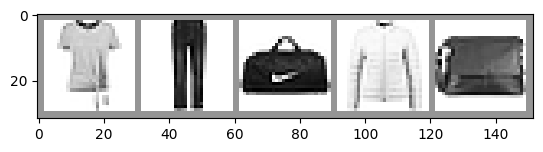

In [8]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
utils.matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(batch_size)))

In [9]:
len(train_data)

60000

In [10]:
train_sample, train_label = train_data[0]
train_sample.shape

torch.Size([1, 28, 28])

## Defining Model Architecture

Let's go for 3 convolutions, 2 fully-connected layers, options for activation (ReLU, sigmoid, tanh), and options for pooling (max, avg). This also gives me a great chance to 1. test out different model architectures, and 2. to test out the limits of my machine (MacBook Pro M3).

**(model defined in `utils.py`)**

## Instantiating Parameter Dictionary

First we start by getting an idea of how our dimensions look like between layers. We will then use this to fill our parameters dict.

In [11]:
conv_kernel_size = 2
pool_kernel_size = 1
pool_stride = 1

print("First convolutional block")
conv1_output = utils.cnn_dims(28, conv_kernel_size)
print("")
pool1_output = utils.pooling_dims(conv1_output, pool_kernel_size, pool_stride)
print("------")
print("Second convolutional block")
conv2_output = utils.cnn_dims(pool1_output, conv_kernel_size)
print("")
pool2_output = utils.pooling_dims(conv2_output, pool_kernel_size, pool_stride)
print("------")
print("Third convolutional block")
conv3_output = utils.cnn_dims(pool2_output, conv_kernel_size)
print("")
pool3_output = utils.pooling_dims(conv3_output, pool_kernel_size, pool_stride)

First convolutional block
Input matrix size: 28x28
Kernel size: 2x2
Therefore output convolved matrix size: 27x27

Input matrix size: 27x27
Kernel size: 1x1 + stride: 1
Therefore output pooled matrix size: 27x27
------
Second convolutional block
Input matrix size: 27x27
Kernel size: 2x2
Therefore output convolved matrix size: 26x26

Input matrix size: 26x26
Kernel size: 1x1 + stride: 1
Therefore output pooled matrix size: 26x26
------
Third convolutional block
Input matrix size: 26x26
Kernel size: 2x2
Therefore output convolved matrix size: 25x25

Input matrix size: 25x25
Kernel size: 1x1 + stride: 1
Therefore output pooled matrix size: 25x25


In [12]:
my_params = {
    # number of output channels for each convolution
    # good rule of thumb is to double every time
    'conv1_out_channels':32,
    'conv2_out_channels':64,
    'conv3_out_channels':128,
    # number of fully-connected layers - max 4
    'fc1_in_features':128 * 25 * 25, # x * y * y, where x=conv3_out_channels and y=dim(conv3_out_channels)
    'fc1_out_features':256, # perhaps we can halve every time now?
    'fc2_out_features':128,
    'fc3_out_features':64,
    # kernel size - same for all convolutions and for all poolings
    'conv_kernel_size':2,
    'pool_kernel_size':1,
    # stride - same for all convolutions and for all poolings
    'conv_stride':1,
    'pool_stride':1,
    # desired pooling type - either of {'max', 'avg'}
    'pool_type': 'max',
    # desired activation - either of {'relu', 'sigmoid', 'tanh'}
    'activation_type': 'relu',
    # optimizer - either of {'sgd', 'adam'}
    'optimizer':'sgd'
}

# instantiating the model
fashion_classifier_model = utils.MyFashionClassifier(my_params)

In [13]:
fashion_classifier_model

MyFashionClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=80000, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [14]:
type(fashion_classifier_model)

utils.MyFashionClassifier

## Defining Loss Function + Optimizer

In [15]:
loss_fn = torch.nn.CrossEntropyLoss() 

In [16]:
my_optimizer = utils.choose_optimizer(
    model=fashion_classifier_model, 
    optimizer_choice=my_params['optimizer'], 
    learning_rate=0.001,
    momentum=0.9
    )

## Model Training

In [17]:
def train_model(
        model, params, optimizer, loss_fn, training_loader, num_epochs=10
    ):
    
    losses = []
    accuracies = []

    # iterating over number of epochs
    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_correct = 0
        epoch_samples = 0

        for i, (inputs, labels) in enumerate(training_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            
            predicted = torch.argmax(outputs, 1)
            epoch_correct += (predicted == labels).sum().item()
            epoch_samples += labels.size(0)

            if (i + 1) % 1000 == 0:
                batch_loss = epoch_loss / (i + 1)
                losses.append(batch_loss)

                accuracy = 100 * epoch_correct / epoch_samples
                accuracies.append(accuracy)

                print(f'Epoch [{epoch+1}/{num_epochs}], Batch {i+1}, Loss: {batch_loss:.4f}, Accuracy: {accuracy:.4f}')

        # End of epoch logging
        epoch_loss_avg = epoch_loss / len(training_loader)
        losses.append(epoch_loss_avg)
        accuracy = 100 * epoch_correct / epoch_samples
        accuracies.append(accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss_avg:.4f}, Accuracy: {accuracy:.4f}')
        
        utils.plot_loss_accuracy_curves(losses, accuracies, epoch+1)

    return losses, accuracies

Epoch [1/3], Batch 1000, Loss: 0.3110, Accuracy: 89.0000
Epoch [1/3], Batch 2000, Loss: 0.3070, Accuracy: 88.7800
Epoch [1/3], Batch 3000, Loss: 0.3052, Accuracy: 88.8333
Epoch [1/3], Batch 4000, Loss: 0.3034, Accuracy: 88.9750
Epoch [1/3], Batch 5000, Loss: 0.2994, Accuracy: 89.0400
Epoch [1/3], Batch 6000, Loss: 0.2954, Accuracy: 89.1833
Epoch [1/3], Batch 7000, Loss: 0.2948, Accuracy: 89.1600
Epoch [1/3], Batch 8000, Loss: 0.2948, Accuracy: 89.1100
Epoch [1/3], Batch 9000, Loss: 0.2927, Accuracy: 89.2044
Epoch [1/3], Batch 10000, Loss: 0.2913, Accuracy: 89.2620
Epoch [1/3], Batch 11000, Loss: 0.2890, Accuracy: 89.3036
Epoch [1/3], Batch 12000, Loss: 0.2875, Accuracy: 89.3733
Epoch [1/3], Loss: 0.2875, Accuracy: 89.3733


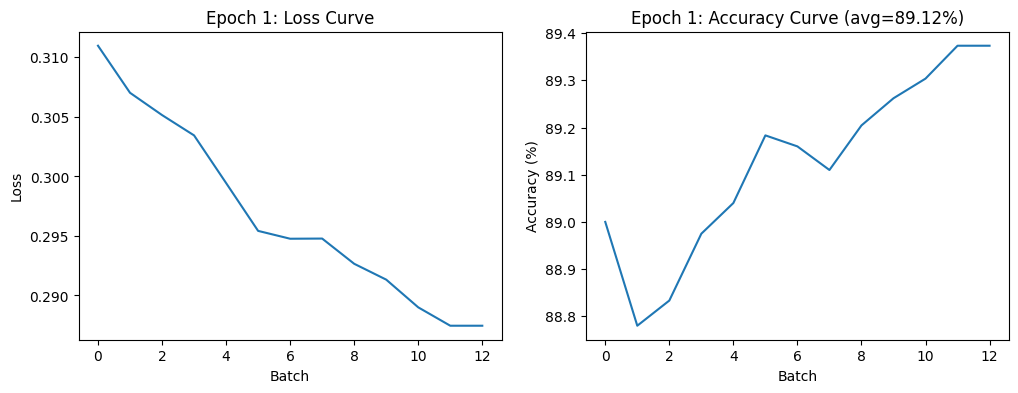

Epoch [2/3], Batch 1000, Loss: 0.2214, Accuracy: 92.4200
Epoch [2/3], Batch 2000, Loss: 0.2289, Accuracy: 92.0200
Epoch [2/3], Batch 3000, Loss: 0.2323, Accuracy: 91.6333
Epoch [2/3], Batch 4000, Loss: 0.2356, Accuracy: 91.3900
Epoch [2/3], Batch 5000, Loss: 0.2347, Accuracy: 91.3720
Epoch [2/3], Batch 6000, Loss: 0.2327, Accuracy: 91.4133
Epoch [2/3], Batch 7000, Loss: 0.2300, Accuracy: 91.5057
Epoch [2/3], Batch 8000, Loss: 0.2286, Accuracy: 91.6150
Epoch [2/3], Batch 9000, Loss: 0.2269, Accuracy: 91.6622
Epoch [2/3], Batch 10000, Loss: 0.2267, Accuracy: 91.7000
Epoch [2/3], Batch 11000, Loss: 0.2254, Accuracy: 91.6836
Epoch [2/3], Batch 12000, Loss: 0.2256, Accuracy: 91.6767
Epoch [2/3], Loss: 0.2256, Accuracy: 91.6767


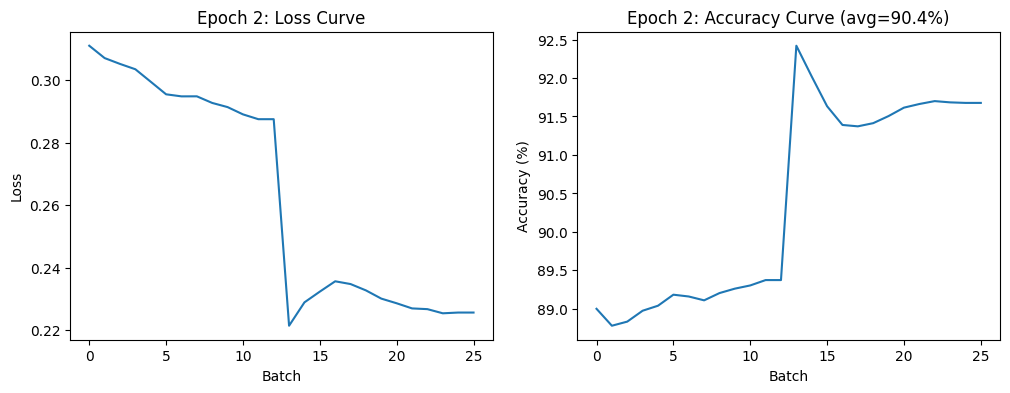

Epoch [3/3], Batch 1000, Loss: 0.1818, Accuracy: 93.8000
Epoch [3/3], Batch 2000, Loss: 0.1759, Accuracy: 93.7000
Epoch [3/3], Batch 3000, Loss: 0.1780, Accuracy: 93.4933
Epoch [3/3], Batch 4000, Loss: 0.1752, Accuracy: 93.5800
Epoch [3/3], Batch 5000, Loss: 0.1764, Accuracy: 93.4760
Epoch [3/3], Batch 6000, Loss: 0.1766, Accuracy: 93.4400
Epoch [3/3], Batch 7000, Loss: 0.1770, Accuracy: 93.4714
Epoch [3/3], Batch 8000, Loss: 0.1787, Accuracy: 93.4400
Epoch [3/3], Batch 9000, Loss: 0.1782, Accuracy: 93.4289
Epoch [3/3], Batch 10000, Loss: 0.1783, Accuracy: 93.4440
Epoch [3/3], Batch 11000, Loss: 0.1786, Accuracy: 93.4436
Epoch [3/3], Batch 12000, Loss: 0.1793, Accuracy: 93.3967
Epoch [3/3], Loss: 0.1793, Accuracy: 93.3967


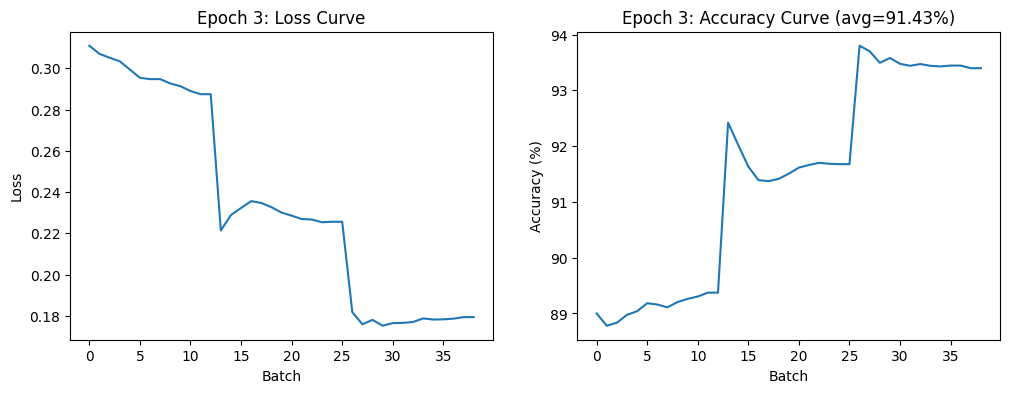

In [19]:
losses, accuracies = train_model(
    model=fashion_classifier_model, 
    params=my_params, 
    optimizer=my_optimizer, 
    loss_fn=loss_fn, 
    training_loader=training_loader,
    num_epochs=3
    )

In [20]:
# Variables to keep track of metrics
correct = 0
total = 0

fashion_classifier_model.eval()

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = fashion_classifier_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Accuracy of the model on the test images: 90.77%
